In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from transformers import BertTokenizer, BertModel
import torch
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm
pd.set_option('display.max_columns', None)

In [7]:
data = pd.read_csv('../BindDBdata/OpenTarget/opentarget_drug_target_protein_coding_DTI_dataset.csv')
data.rename(columns={'canonicalSmiles':'smiles', 'Sequence':'sequence'}, inplace=True)
data.head()

,id_x,smiles,inchiKey,drugType,blackBoxWarning,name,hasBeenWithdrawn,tradeNames,synonyms_x,crossReferences,childChemblIds,description,yearOfFirstApproval,maximumClinicalTrialPhase,isApproved,linkedDiseases,linkedTargets,parentId,linkedProteinIds,id_y,approvedSymbol,biotype,transcriptIds,canonicalTranscript,canonicalExons,genomicLocation,approvedName,go,synonyms_y,symbolSynonyms,nameSynonyms,functionDescriptions,subcellularLocations,obsoleteSymbols,obsoleteNames,constraint,proteinIds,dbXrefs,homologues,tractability,pathways,targetClass,safetyLiabilities,alternativeGenes,tep,chemicalProbes,hallmarks,From,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,sequence,EC number,Active site,Binding site,Rhea ID,Pathway,Catalytic activity,Tissue specificity
0,CHEMBL1106,NC1=NCC2c3ccccc3Cc3ccccc3N12,WHWZLSFABNNENI-UHFFFAOYSA-N,Small molecule,False,EPINASTINE,False,[],"['Elestat', 'Epinastine', 'Purivist', 'WAL-801']","{'PubChem': ['29217549', '50111706', '90340676...",['CHEMBL1200491'],Small molecule drug with a maximum clinical tr...,2003.0,4.0,True,"{'rows': ['EFO_1001417', 'EFO_0005854', 'EFO_0...","{'rows': ['ENSG00000196639'], 'count': 1}",NaN,ENSG00000196639,ENSG00000196639,HRH1,protein_coding,"['ENST00000413416', 'ENST00000438284', 'ENST00...","{'id': 'ENST00000431010', 'chromosome': '3', '...","['11259003', '11263557', '11154493', '11154554']","{'chromosome': '3', 'start': 11137093, 'end': ...",histamine receptor H1,"[{'id': 'GO:0005886', 'source': 'GO_REF:000002...","[{'label': 'Histamine H1 receptor', 'source': ...","[{'label': 'HRH1', 'source': 'uniprot'}, {'lab...","[{'label': 'Histamine H1 receptor', 'source': ...","['In peripheral tissues, the H1 subclass of hi...","[{'location': 'Cell membrane', 'source': 'unip...",[],[],"[{'constraintType': 'syn', 'score': -0.61009, ...","[{'id': 'P35367', 'source': 'uniprot_swissprot...","[{'id': '5182', 'source': 'HGNC'}, {'id': '3RZ...","[{'speciesId': '9606', 'speciesName': 'Human',...","[{'modality': 'SM', 'id': 'Approved Drug', 'va...","[{'pathwayId': 'R-HSA-390650', 'pathway': 'His...","[{'id': 0, 'label': 'Membrane receptor', 'leve...","[{'event': 'allergic responses of flare, flush...",NaN,NaN,"[{'drugId': 'CHEMBL505', 'id': 'CHLORPHENIRAMI...",NaN,ENSG00000196639,P35367,reviewed,HRH1_HUMAN,Histamine H1 receptor (H1-R) (H1R) (HH1R),HRH1,Homo sapiens (Human),487.0,MSLPNSSCLLEDKMCEGNKTTMASPQLMPLVVVLSTICLVTVGLNL...,NaN,NaN,"BINDING 107; /ligand=""histamine""; /ligand_id=""...",NaN,NaN,NaN,NaN
1,CHEMBL1106,NC1=NCC2c3ccccc3Cc3ccccc3N12,WHWZLSFABNNENI-UHFFFAOYSA-N,Small molecule,False,EPINASTINE,False,[],"['Elestat', 'Epinastine', 'Purivist', 'WAL-801']","{'PubChem': ['29217549', '50111706', '90340676...",['CHEMBL1200491'],Small molecule drug with a maximum clinical tr...,2003.0,4.0,True,"{'rows': ['EFO_1001417', 'EFO_0005854', 'EFO_0...","{'rows': ['ENSG00000196639'], 'count': 1}",NaN,ENSG00000196639,ENSG00000196639,HRH1,protein_coding,"['ENST00000413416', 'ENST00000438284', 'ENST00...","{'id': 'ENST00000431010', 'chromosome': '3', '...","['11259003', '11263557', '11154493', '11154554']","{'chromosome': '3', 'start': 11137093, 'end': ...",histamine receptor H1,"[{'id': 'GO:0005886', 'source': 'GO_REF:000002...","[{'label': 'Histamine H1 receptor', 'source': ...","[{'label': 'HRH1', 'source': 'uniprot'}, {'lab...","[{'label': 'Histamine H1 receptor', 'source': ...","['In peripheral tissues, the H1 subclass of hi...","[{'location': 'Cell membrane', 'source': 'unip...",[],[],"[{'constraintType': 'syn', 'score': -0.61009, ...","[{'id': 'P35367', 'source': 'uniprot_swissprot...","[{'id': '5182', 'source': 'HGNC'}, {'id': '3RZ...","[{'speciesId': '9606', 'speciesName': 'Human',...","[{'modality': 'SM', 'id': 'Approved Drug', 'va...","[{'pathwayId': 'R-HSA-390650', 'pathway': 'His...","[{'id': 0, 'label': 'Membrane receptor', 'leve...","[{'event': 'allergic responses of flare, flush...",NaN,NaN,"[{'drugId': 'CHEMBL505', 'id': 'CHLORPHENIRAMI...",NaN,ENSG00000196639,C9J2E6,un

In [41]:
# Function to generate negative pairs
def generate_negative_pairs(df, negative_positive_ratio=1):
    # Extract unique drugs and targets
    unique_drugs = df['smiles'].unique()
    unique_targets = df['sequence'].unique()
    
    # Create a set of positive pairs for quick lookup
    positive_pairs = set(zip(df['smiles'], df['sequence']))
    
    # Calculate the number of negative pairs needed
    num_positive_pairs = len(df)
    num_negative_pairs = int(num_positive_pairs * negative_positive_ratio)
    
    # Generate negative pairs
    negative_pairs = set()
    while len(negative_pairs) < num_negative_pairs:
        drug = random.choice(unique_drugs)
        target = random.choice(unique_targets)
        if (drug, target) not in positive_pairs and (drug, target) not in negative_pairs:
            negative_pairs.add((drug, target))
    
    # Create a DataFrame for negative pairs
    negative_df = pd.DataFrame(list(negative_pairs), columns=['smiles', 'sequence'])
    return negative_df

In [42]:
# Generate negative pairs with a 1:1 ratio
negative_df = generate_negative_pairs(data, negative_positive_ratio=1)
len(negative_df)

70043

In [43]:
# Rearrange columns for clarity
negative_df = negative_df[['smiles','sequence']]
positive_df = data[['smiles','sequence']]

In [44]:
# Add labels to positive (1) and negative (0) dataframes

positive_df['label'] = 1

negative_df['label'] = 0

/var/folders/7_/j8_cym2s23jfxbknz2gsv_h80000gn/T/ipykernel_83463/4011087039.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_df['label'] = 1


In [45]:
# Combine positive and negative datasets
combined_df = pd.concat([positive_df, negative_df], ignore_index=True)

In [56]:
torch.save(combined_df, '../BindDBdata/OpenTarget/opentarget_drug_target_protein_coding_DTI_dataset_combined.pt')

In [46]:
len(positive_df)/len(combined_df)

0.5

In [14]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load ChemRoBERTa tokenizer and model
chem_tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
chem_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# Load ESM2 tokenizer and model
esm_tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
esm_model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from transformers import AutoTokenizer, AutoModel

# esm_tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")
# esm_model = AutoModel.from_pretrained("facebook/esm2_t33_650M_UR50D")
# print(esm_model.config.hidden_size)  # Should output 768


In [16]:
def extract_chem_features(smiles):
    """Extract ChemRoBERTa features from SMILES."""
    try:
        tokens = chem_tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            embeddings = chem_model(**tokens).last_hidden_state.mean(dim=1).squeeze().numpy()
        return embeddings
    except:
        return np.zeros(768)  # Return zero vector if extraction fails

def extract_esm_features(sequence):
    """Extract ESM2 features from protein sequence."""
    try:
        tokens = esm_tokenizer(sequence, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            embeddings = esm_model(**tokens).last_hidden_state.mean(dim=1).squeeze().numpy()
        return embeddings
    except:
        return np.zeros(320)  # Return zero vector if extraction fails

In [17]:
print(esm_model.config.hidden_size)  # Should output 768


320


In [49]:
# Function to featurize drug SMILES into molecular fingerprints
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    else:
        return np.zeros(2048)

# Load ProtBERT for protein embedding
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert")
model = BertModel.from_pretrained("Rostlab/prot_bert")

# Function to featurize protein sequences
def featurize_protein(sequence):
    inputs = tokenizer(sequence, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

python(37279) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
# Featurize drugs
# Extract unique drugs and proteins
unique_drugs = combined_df[['smiles']].drop_duplicates()
unique_proteins = combined_df[['sequence']].drop_duplicates()


In [19]:
len(unique_drugs)

3654

In [20]:
len(unique_proteins)

7356

In [21]:
# Extract features for unique drugs
tqdm.pandas()  # Enable progress bar for pandas
unique_drugs['drug_features'] = unique_drugs['smiles'].progress_apply(extract_chem_features)

100%|██████████| 3654/3654 [01:21<00:00, 44.59it/s]


In [22]:
# Extract features for unique proteins
unique_proteins['protein_features'] = unique_proteins['sequence'].progress_apply(extract_esm_features)

100%|██████████| 7356/7356 [1:28:48<00:00,  1.38it/s]     


In [47]:
# Merge features back into the combined dataframe
combined_df = combined_df.merge(unique_drugs, on='smiles', how='left')
combined_df = combined_df.merge(unique_proteins, on='sequence', how='left')

In [48]:
combined_df['label'].value_counts()

label
1    70043
0    70043
Name: count, dtype: int64

In [3]:
combined_df = torch.load('../BindDBdata/OpenTarget/opentarget_drug_target_protein_coding_DTI_dataset_combined.pt')
combined_df.head()

/var/folders/7_/j8_cym2s23jfxbknz2gsv_h80000gn/T/ipykernel_1683/37836786.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  combined_df = torch.load('../BindDBdata/OpenTarg

,smiles,sequence,label,drug_features,protein_features
0,NC1=NCC2c3ccccc3Cc3ccccc3N12,MSLPNSSCLLEDKMCEGNKTTMASPQLMPLVVVLSTICLVTVGLNL...,1,"[0.5923203, 0.45878562, 0.28397772, 0.38408384...","[-0.09248094, -0.023907714, 0.13759845, 0.3597..."
1,NC1=NCC2c3ccccc3Cc3ccccc3N12,MSLPNSSCLLED,1,"[0.5923203, 0.45878562, 0.28397772, 0.38408384...","[0.074877255, -0.29347023, 0.15136974, 0.10324..."
2,CCC(=O)O[C@](Cc1ccccc1)(c1ccccc1)[C@H](C)CN(C)...,MDSSAAPTNASNCTDALAYSSCSPAPSPGSWVNLSHLDGNLSDPCG...,1,"[0.5573068, 0.80988187, 0.34692556, -0.1426545...","[-0.09040368, 0.039952643, 0.20119138, 0.35730..."
3,CCC(=O)O[C@](Cc1ccccc1)(c1ccccc1)[C@H](C)CN(C)...,MVQARTGFCKKQQELWQRRKEAAEALGTRKVSVLLATSHSGARPAV...,1,"[0.5573068, 0.80988187, 0.34692556, -0.1426545...","[-0.056361884, -0.18351607, 0.038147006, 0.133..."
4,CCC(=O)O[C@](Cc1ccccc1)(c1ccccc1)[C@H](C)CN(C)...,MSDAQLGPLRLTLLSVSARTGFCKKQQELWQRRKEAAEALGTRKVS...,1,"[0.5573068, 0.80988187, 0.34692556, -0.1426545...","[-0.12179501, -0.05067268, 0.18052118, 0.31047..."


In [4]:
# DataFrame to store AUCs

auc_history = pd.DataFrame(columns=['epoch', 'Train Loss', 'Train AUC', 'Val Loss', 'Val AUC'])

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Define dataset
class DTI_Dataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return {
            'drug_features': torch.tensor(np.asarray(row['drug_features'], dtype=np.float32)),
            'protein_features': torch.tensor(np.asarray(row['protein_features'], dtype=np.float32)),
            'label': torch.tensor(float(row['label']), dtype=torch.float32),
        }

# Define Diffusion Generative Model
class DiffusionGenerativeModel(nn.Module):
    def __init__(self, drug_input_dim, protein_input_dim, hidden_dim, num_timesteps):
        super(DiffusionGenerativeModel, self).__init__()
        self.num_timesteps = num_timesteps
        self.drug_encoder = nn.Linear(drug_input_dim, hidden_dim)
        self.protein_encoder = nn.Linear(protein_input_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)
        self.denoise_model = nn.Linear(hidden_dim * 2, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, 1)
        self.activation = nn.ReLU()

    def forward(self, drug_features, protein_features, t):
        # Encode drug and protein features
        drug_embedding = self.activation(self.drug_encoder(drug_features))
        protein_embedding = self.activation(self.protein_encoder(protein_features))

        # Concatenate embeddings
        combined = torch.cat((drug_embedding, protein_embedding), dim=-1)
        combined = self.layer_norm(combined)
        combined = self.dropout(combined)

        # Add learnable timestep embedding
        t_embedding = nn.Embedding(self.num_timesteps, combined.size(1))(t.long())
        combined += t_embedding

        # Denoise process
        denoised = self.activation(self.denoise_model(combined))

        # Classification layer
        output = torch.sigmoid(self.classifier(denoised))
        return output

    def add_noise(self, x, noise_level=0.1):
        noise = noise_level * torch.randn_like(x)
        return x + noise

# Load data
# Assuming `combined_df` is a pandas DataFrame containing all necessary columns
train_df, temp_df = train_test_split(combined_df, test_size=0.3, stratify=combined_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

train_dataset = DTI_Dataset(train_df)
val_dataset = DTI_Dataset(val_df)
test_dataset = DTI_Dataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
# Verify feature dimensions
for batch in train_loader:
    drug_input_dim = batch['drug_features'].shape[1]  # Dynamically determine drug input dimension
    protein_input_dim = batch['protein_features'].shape[1]  # Dynamically determine protein input dimension
    break

# Initialize model, optimizer, and loss function
num_timesteps = 10
model = DiffusionGenerativeModel(drug_input_dim=drug_input_dim, protein_input_dim=protein_input_dim, hidden_dim=512, num_timesteps=num_timesteps)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
pos_weight = torch.tensor([len(train_df) / train_df['label'].sum() - 1], dtype=torch.float32)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Training and Validation Loop
for epoch in range(200):
    model.train()
    total_loss = 0
    val_total_loss = 0
    train_predictions, train_labels = [], []

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        drug_features = batch['drug_features']
        protein_features = batch['protein_features']
        labels = batch['label']

        # Add noise to the features
        noisy_drug_features = model.add_noise(drug_features, noise_level=0.1)
        noisy_protein_features = model.add_noise(protein_features, noise_level=0.1)

        optimizer.zero_grad()
        outputs = model(noisy_drug_features, noisy_protein_features, torch.randint(0, num_timesteps, (drug_features.size(0),))).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Store predictions and labels for AUC calculation
        train_predictions.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Calculate AUC for training
    train_auc = roc_auc_score(train_labels, train_predictions)
    if epoch % 10 == 0:
        print(f"Epoch {epoch + 1} - Train Loss: {total_loss / len(train_loader):.4f}, Train AUC: {train_auc:.4f}")

    # Validation AUC
    model.eval()
    val_predictions, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            drug_features = batch['drug_features']
            protein_features = batch['protein_features']
            labels = batch['label']

            # Add noise to the features
            noisy_drug_features = model.add_noise(drug_features, noise_level=0.1)
            noisy_protein_features = model.add_noise(protein_features, noise_level=0.1)

            outputs = model(noisy_drug_features, noisy_protein_features, torch.randint(0, num_timesteps, (drug_features.size(0),))).squeeze()
            val_predictions.extend(torch.sigmoid(outputs).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_loss = criterion(outputs, labels)
            val_total_loss += val_loss.item()

    val_auc = roc_auc_score(val_labels, val_predictions)
    if epoch % 10 == 0:
        print(f"Epoch {epoch + 1} - Validation Loss: {val_total_loss / len(val_loader):.4f}, Validation AUC: {val_auc:.4f}")
    
     # Save AUC to DataFrame
    new_row = {'epoch': epoch + 1, 'Train Loss': total_loss / len(train_loader), 'Train AUC': train_auc, 'Val Loss': val_total_loss / len(val_loader), 'Val AUC': val_auc}
    auc_history = pd.concat([auc_history, pd.DataFrame([new_row])], ignore_index=True)

# Test AUC
model.eval()
test_predictions, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        drug_features = batch['drug_features']
        protein_features = batch['protein_features']
        labels = batch['label']

        # Add noise to the features
        noisy_drug_features = model.add_noise(drug_features, noise_level=0.1)
        noisy_protein_features = model.add_noise(protein_features, noise_level=0.1)

        outputs = model(noisy_drug_features, noisy_protein_features, torch.randint(0, num_timesteps, (drug_features.size(0),))).squeeze()
        test_predictions.extend(torch.sigmoid(outputs).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_auc = roc_auc_score(test_labels, test_predictions)
print(f"Test AUC: {test_auc:.4f}")


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Test Evaluation with Additional Metrics
model.eval()
test_predictions, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        drug_features = batch['drug_features']
        protein_features = batch['protein_features']
        labels = batch['label']

        # Add noise to the features
        noisy_drug_features = model.add_noise(drug_features, noise_level=0.1)
        noisy_protein_features = model.add_noise(protein_features, noise_level=0.1)

        outputs = model(noisy_drug_features, noisy_protein_features, torch.randint(0, num_timesteps, (drug_features.size(0),))).squeeze()
        test_predictions.extend(torch.sigmoid(outputs).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Convert predictions to binary
test_predictions_binary = (np.array(test_predictions) >= 0.5).astype(int)

# Calculate Metrics
test_auc = roc_auc_score(test_labels, test_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions_binary)
test_precision = precision_score(test_labels, test_predictions_binary, zero_division=0)
test_recall = recall_score(test_labels, test_predictions_binary, zero_division=0)
test_f1 = f1_score(test_labels, test_predictions_binary, zero_division=0)

# Sensitivity and Specificity
tn, fp, fn, tp = confusion_matrix(test_labels, test_predictions_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

# Print Results
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall (Sensitivity): {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test Specificity: {test_specificity:.4f}")

In [52]:
auc_history.tail()

,epoch,Train Loss,Train AUC,Val Loss,Val AUC
995,996,0.518161,0.977836,0.525459,0.969087
996,997,0.518434,0.977792,0.525553,0.969148
997,998,0.518267,0.978113,0.524556,0.969479
998,999,0.518144,0.978027,0.525943,0.969005
999,1000,0.518560,0.977878,0.524776,0.969310


In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

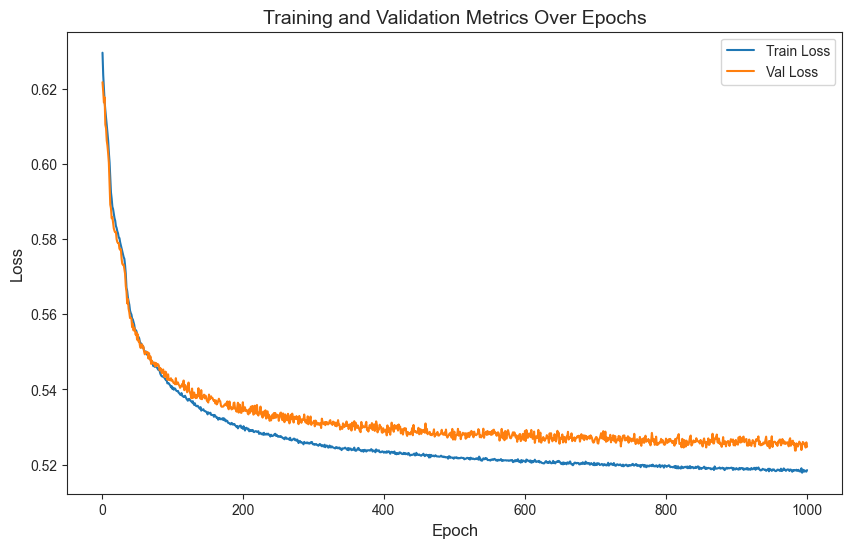

In [55]:
# Load metrics

metrics = auc_history
metrics[['epoch', 'Train Loss', 'Train AUC', 'Val Loss', 'Val AUC']] = metrics[['epoch', 'Train Loss', 'Train AUC', 'Val Loss', 'Val AUC']].astype(float)

# Plot the training loss over epochs using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=metrics, x='epoch', y='Train Loss', label='Train Loss')
sns.lineplot(data=metrics, x='epoch', y='Val Loss', label='Val Loss')
# sns.lineplot(data=metrics, x='epoch', y='Train AUC', label='Train AUC')
# sns.lineplot(data=metrics, x='epoch', y='Val AUC', label='Val AUC')
# sns.lineplot(data=metrics, x='Epoch', y='Valid_RMSE', label='Valid_RMSE')
# sns.lineplot(data=metrics, x='Epoch', y='Valid_MAE', label='Valid_MAE')
# Add titles and labels
plt.title('Training and Validation Metrics Over Epochs', fontsize=14)
# Define the range of tick positions
# plt.xticks(ticks=np.arange(0, epochs+1, 500))  # Adjust step size as needed
# plt.xlim(-50, epochs+50)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(False)
# Show the plot
plt.show()